# Learning Data Augmentation with Bilevel Optimization For Image Classification


- ## Main repository: https://github.com/ElementAI/bilevel_augment 
- ## Experiment manager library: https://github.com/ElementAI/haven

![](https://github.com/ElementAI/bilevel_augment/raw/master/docs/model_new.png)

- Visualize results with Haven Dashboard 
- Define experiment configuration
- Load CIFAR10 dataset and show  example images
- Load and Show model architecture
- Train Classifier only approach
- Test Classifier only approach
- Show example augmentations of augmentor
- Train Classifier + Augmentor
- Test Classifier + Augmentor
- Train large-scale experiments


# Visualize results with Haven Dashboard

In [1]:
# Visualize results with Haven Dashboard

from haven import haven_jupyter as hj
from haven import haven_results as hr
from haven import haven_utils as hu

savedir_base = '/mnt/results/toolkit/bilevel_augment'
exp_list = None

rm = hr.ResultManager(exp_list=exp_list, 
                      savedir_base=savedir_base, 
                      verbose=0
                     )
y_metrics = ['test_acc']
bar_agg = 'max'
mode = 'bar'
legend_list = ['model.netA.name']
title_list = 'dataset.name'
legend_format = 'Augmentation Netwok: {}'
filterby_list = {'dataset':{'name':'cifar10'}, 'model':{'netC':{'name':'resnet18_meta_2'}}}
# launch dashboard
hj.get_dashboard(rm, vars(), wide_display=True)

100%|██████████| 7/7 [00:00<00:00, 822.32it/s]


'Selected 2/6 experiments using "filterby_list"'

<IPython.core.display.Javascript object>

Output()

In [2]:
# imports and functions
import sys, os
import pprint
path = '/mnt/home/projects/bilevel_augment'
sys.path.insert(0, path)
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

def get_batch(batch):  
    batch['images'] = batch['images'][None].cuda()
    batch['labels'] = torch.as_tensor(batch['labels'])[None].cuda()
    return batch
    
def get_exp_dict(netA):
    exp_dict = {
          'model': {'name': 'blvl',
                   'netA': netA,
                   'netC': {'name': 'resnet18_meta_2',
                            'opt': {'lr': 0.1,
                                    'momentum': 0.9,
                                    'name': 'sgd',
                                    'sched': True,
                                    'weight_decay': 0.0005}}},
          'dataset': {'colorjitter': False,
                     'name': 'cifar10',
                     'transform_lvl': 1.5,
                     'val_transform': 'identity'},

         'batch': {'factor': 1, 'size': 128},
         'dataset_size': {'test': None, 'train': None},
         'fixedSeed': 6442,
         'mixTrainVal': True,

         'n_inner_iter': 1,
         'niter': 201,
         'predParams': None,
         'testTimeDA': 0,
         'valratio': 0.2}
    return exp_dict

         
from src import models

import torch
from src.models import get_model
from src.datasets import get_dataset
import trainval

# Load dataset
exp_dict = get_exp_dict(netA=None)
datadir_base = '/mnt/datasets'
from haven import haven_utils as hu
import pylab as plt
import torchvision

def denorm(img):
    return torch.as_tensor(hu.get_image(img, denorm=True)).squeeze()


# Define experiment configuration

In [5]:
# netA = {'factor': 1,
#                     'name': 'small_affine',
#                     'opt': {'lr': 0.2,
#                             'momentum': 0.9,
#                             'name': 'sgd',
#                             'sched': False,
#                             'weight_decay': 0.01},
#                     'transform': 'affine'}

exp_dict = get_exp_dict(netA=None)
pprint.pprint(exp_dict)

{'batch': {'factor': 1, 'size': 128},
 'dataset': {'colorjitter': False,
             'name': 'cifar10',
             'transform_lvl': 1.5,
             'val_transform': 'identity'},
 'dataset_size': {'test': None, 'train': None},
 'fixedSeed': 6442,
 'mixTrainVal': True,
 'model': {'name': 'blvl',
           'netA': None,
           'netC': {'name': 'resnet18_meta_2',
                    'opt': {'lr': 0.1,
                            'momentum': 0.9,
                            'name': 'sgd',
                            'sched': True,
                            'weight_decay': 0.0005}}},
 'n_inner_iter': 1,
 'niter': 201,
 'predParams': None,
 'testTimeDA': 0,
 'valratio': 0.2}


# Load CIFAR10 dataset and show example images

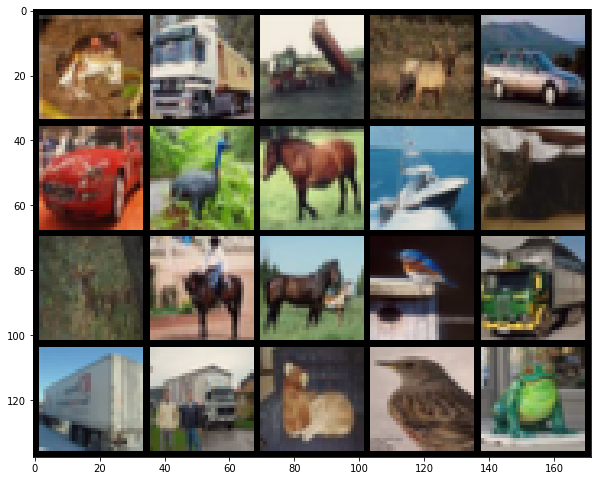

In [6]:
# Load CIFAR10 dataset and show example images
from src.datasets import get_dataset

# load datasets
trainset = get_dataset(exp_dict['dataset'], 'train',
                           exp_dict=exp_dict, datadir_base=datadir_base,
                           n_samples=exp_dict['dataset_size']['train'],
                           transform_lvl=exp_dict['dataset']['transform_lvl'],
                           colorjitter=exp_dict['dataset'].get('colorjitter'))

testset = get_dataset(exp_dict['dataset'], 'test',
                          exp_dict=exp_dict, datadir_base=datadir_base,
                          n_samples=exp_dict['dataset_size']['test'],
                          transform_lvl=0,
                          val_transform=exp_dict['dataset']['val_transform'])

# show example images
img_list = [denorm(trainset[i]['images']) for i in range(20)]
grid_img = torchvision.utils.make_grid(img_list, nrow=5)

plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))


In [11]:
# Load and Show model architecture
netA = {'factor': 1,
                    'name': 'small_affine',
                    'opt': {'lr': 0.2,
                            'momentum': 0.9,
                            'name': 'sgd',
                            'sched': False,
                            'weight_decay': 0.01},
                    'transform': 'affine'}
exp_dict = get_exp_dict(netA)
model = get_model(exp_dict, trainset, device=torch.device("cuda"))
model.netA

Augmenter(
  (net): DataParallel(
    (module): smallAffine(
      (fc_loc): Sequential(
        (0): Linear(in_features=6, out_features=6, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=6, out_features=60, bias=True)
        (4): ReLU()
        (5): Dropout(p=0.2, inplace=False)
      )
      (lin1): Linear(in_features=60, out_features=6, bias=True)
    )
  )
)

#  Train classifier only

Only the blue region
![](https://github.com/ElementAI/bilevel_augment/raw/master/docs/model_new.png)

In [12]:
#  Train classifier only
netA = None
exp_dict = get_exp_dict(netA)

model = get_model(exp_dict, trainset, device=torch.device("cuda"))

n_iters=100

with tqdm(total=n_iters) as pbar:
    for i in range(n_iters):
        batch = get_batch(trainset[i] ) 
        
        # train on batch
        train_loss = model.netC.train_on_batch(batch)
        
        pbar.set_description("Training - Loss: %.3f" % (train_loss))
        pbar.update(1)

#  Test classifier only

In [13]:
#  Test classifier only

# define experiment dict
netA = None
exp_dict = get_exp_dict(netA)
exp_id = hu.hash_dict(exp_dict)
pprint.pprint(exp_dict)

# get path
savedir_base = '/mnt/results/toolkit/bilevel_augment'
savedir = os.path.join(savedir_base, exp_id)
model_best_path = os.path.join(savedir, 'model_best.pth')

# load best model
model.load_state_dict(hu.torch_load(model_best_path))

# setup test loader
testloader = torch.utils.data.DataLoader(testset, batch_size=exp_dict['batch']['size'],
                                                 shuffle=False,)
# test 
model.test_on_loader(testloader)

Validating - Acc: 92.969:   0%|          | 0/79 [00:00<?, ?it/s]

{'batch': {'factor': 1, 'size': 128},
 'dataset': {'colorjitter': False,
             'name': 'cifar10',
             'transform_lvl': 1.5,
             'val_transform': 'identity'},
 'dataset_size': {'test': None, 'train': None},
 'fixedSeed': 6442,
 'mixTrainVal': True,
 'model': {'name': 'blvl',
           'netA': None,
           'netC': {'name': 'resnet18_meta_2',
                    'opt': {'lr': 0.1,
                            'momentum': 0.9,
                            'name': 'sgd',
                            'sched': True,
                            'weight_decay': 0.0005}}},
 'n_inner_iter': 1,
 'niter': 201,
 'predParams': None,
 'testTimeDA': 0,
 'valratio': 0.2}


{'acc': 90.06}

# Load and Show model architecture

In [14]:
# Load and Show model architecture
netA = {'factor': 1,
                    'name': 'small_affine',
                    'opt': {'lr': 0.2,
                            'momentum': 0.9,
                            'name': 'sgd',
                            'sched': False,
                            'weight_decay': 0.01},
                    'transform': 'affine'}
exp_dict = get_exp_dict(netA)
model = get_model(exp_dict, trainset, device=torch.device("cuda"))
model.netA

Augmenter(
  (net): DataParallel(
    (module): smallAffine(
      (fc_loc): Sequential(
        (0): Linear(in_features=6, out_features=6, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=6, out_features=60, bias=True)
        (4): ReLU()
        (5): Dropout(p=0.2, inplace=False)
      )
      (lin1): Linear(in_features=60, out_features=6, bias=True)
    )
  )
)

# Show augmentations with the augmentor

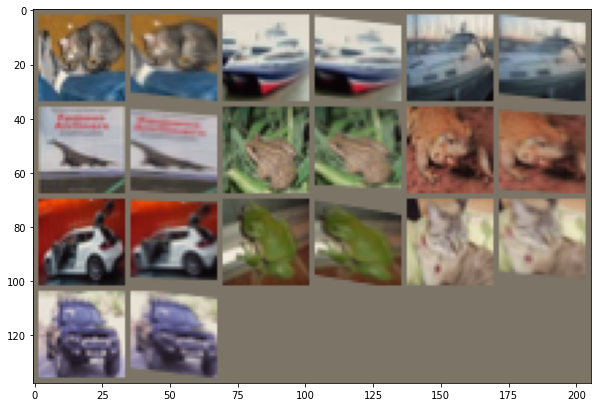

In [15]:
# show augmentations with the augmentor
img_list = []
model.train()
model = get_model(exp_dict, trainset, device=torch.device("cuda"))
for i in  range(10):
    batch = testset[i]    
    batch['images'] = batch['images'][None].cuda()
    batch['labels'] = torch.as_tensor(batch['labels'])[None].cuda()
    images, labels = batch['images'], batch['labels']
    images, labels, transformations = model.netA.apply_augmentation(images, labels)
    img_list += [batch['images'].squeeze()]
    img_list += [images.squeeze()]

plt.figure(figsize=(10,10))
grid_img = torchvision.utils.make_grid(img_list, nrow=6)
plt.imshow(denorm(grid_img).permute(1, 2, 0))

# Train classifier with augmenter

Train both blue and green regions
![](https://github.com/ElementAI/bilevel_augment/raw/master/docs/model_new.png)

In [16]:
# train classifier with augmenter
n_iters=100

model = get_model(exp_dict, trainset, device=torch.device("cuda"))

# feed the augmentor with the test loader
model.netA.on_trainloader_start(0, testloader, model.netC)

model.train()
with tqdm(total=n_iters) as pbar:
    for i in range(n_iters):
        # get a train batch
        batch = get_batch(trainset[i] ) 
        
        # compute augmentor loss
        loss, transformations = model.netA.train_on_batch(batch, netC=model.netC)
        
        # train classifier
        loss += float(model.netC.train_on_batch(batch))
        
        pbar.set_description("Training - Loss: %.3f" % (loss))
        pbar.update(1)

#  Test classifier + augmentor

In [17]:
#  Test classifier + augmentor

# define experiment dict
netA = {'factor': 1,
                    'name': 'small_affine',
                    'opt': {'lr': 0.2,
                            'momentum': 0.9,
                            'name': 'sgd',
                            'sched': False,
                            'weight_decay': 0.01},
                    'transform': 'affine'}
exp_dict = get_exp_dict(netA)
exp_id = hu.hash_dict(exp_dict)

# load model
model = get_model(exp_dict, trainset, device=torch.device("cuda"))

# get path
savedir_base = '/mnt/results/toolkit/bilevel_augment'
savedir = os.path.join(savedir_base, exp_id)
model_best_path = os.path.join(savedir, 'model_best.pth')

# load best model
model.load_state_dict(hu.torch_load(model_best_path))

# setup test loader
testloader = torch.utils.data.DataLoader(testset, batch_size=exp_dict['batch']['size'],
                                                 shuffle=False,)
# test 
model.test_on_loader(testloader)

{'acc': 93.92}

# RUN Large Scale Experiments

In [18]:
# RUN Large Scale Experiments

# define exp_list
exp_list = []

exp_dict = {
          'model': {'name': 'blvl',
                   'netA': None,
                   'netC': {'name': 'resnet18_meta',
                            'opt': {'lr': 0.3,
                                    'momentum': 0.5,
                                    'name': 'sgd',
                                    'sched': True,
                                    'weight_decay': 0.0005}}},
          'dataset': {'colorjitter': False,
                     'name': 'cifar10',
                     'transform_lvl': 1.5,
                     'val_transform': 'identity'},

         'batch': {'factor': 1, 'size': 128},
         'dataset_size': {'test': None, 'train': None},
         'fixedSeed': 6442,
         'mixTrainVal': True,

         'n_inner_iter': 1,
         'niter': 201,
         'predParams': None,
         'testTimeDA': 0,
         'valratio': 0.2}

exp_list += [get_exp_dict(netA=None)]
exp_list += [get_exp_dict(netA={'factor': 1,
                    'name': 'small_affine',
                    'opt': {'lr': 0.2,
                            'momentum': 0.9,
                            'name': 'sgd',
                            'sched': False,
                            'weight_decay': 0.01},
                    'transform': 'affine'})]

for i, exp_dict in enumerate(exp_list):
    print('EXPERIMENT %d/%d\n%s\n\n' % (i+1, len(exp_list), '=============='))
    pprint.pprint(exp_dict)
    


EXPERIMENT 1/2


{'batch': {'factor': 1, 'size': 128},
 'dataset': {'colorjitter': False,
             'name': 'cifar10',
             'transform_lvl': 1.5,
             'val_transform': 'identity'},
 'dataset_size': {'test': None, 'train': None},
 'fixedSeed': 6442,
 'mixTrainVal': True,
 'model': {'name': 'blvl',
           'netA': None,
           'netC': {'name': 'resnet18_meta_2',
                    'opt': {'lr': 0.1,
                            'momentum': 0.9,
                            'name': 'sgd',
                            'sched': True,
                            'weight_decay': 0.0005}}},
 'n_inner_iter': 1,
 'niter': 201,
 'predParams': None,
 'testTimeDA': 0,
 'valratio': 0.2}
EXPERIMENT 2/2


{'batch': {'factor': 1, 'size': 128},
 'dataset': {'colorjitter': False,
             'name': 'cifar10',
             'transform_lvl': 1.5,
             'val_transform': 'identity'},
 'dataset_size': {'test': None, 'train': None},
 'fixedSeed': 6442,
 'mixTrainVal': True,
 'mo

In [19]:
# run experiments sequentially

# exp_dict = {
#           'model': {'name': 'blvl',
#                    'netA': None,
#                    'netC': {'name': 'resnet18_meta',
#                             'opt': {'lr': 0.3,
#                                     'momentum': 0.5,
#                                     'name': 'sgd',
#                                     'sched': True,
#                                     'weight_decay': 0.0005}}},
#           'dataset': {'colorjitter': False,
#                      'name': 'cifar10',
#                      'transform_lvl': 1.5,
#                      'val_transform': 'identity'},

#          'batch': {'factor': 1, 'size': 128},
#          'dataset_size': {'test': None, 'train': None},
#          'fixedSeed': 6442,
#          'mixTrainVal': True,

#          'n_inner_iter': 1,
#          'niter': 201,
#          'predParams': None,
#          'testTimeDA': 0,
#          'valratio': 0.2}


for i, exp_dict in enumerate(exp_list):
    print('EXPERIMENT %d/%d\n%s\n\n' % (i+1, len(exp_list), '=============='))

    trainval.trainval(exp_dict=exp_dict,
                         savedir_base = '/mnt/results/demo/bilevel_augment',
                         datadir_base='/mnt/datasets'
                         )

EXPERIMENT 1/2


{'batch': {'factor': 1, 'size': 128},
 'dataset': {'colorjitter': False,
             'name': 'cifar10',
             'transform_lvl': 1.5,
             'val_transform': 'identity'},
 'dataset_size': {'test': None, 'train': None},
 'fixedSeed': 6442,
 'mixTrainVal': True,
 'model': {'name': 'blvl',
           'netA': None,
           'netC': {'name': 'resnet18_meta_2',
                    'opt': {'lr': 0.1,
                            'momentum': 0.9,
                            'name': 'sgd',
                            'sched': True,
                            'weight_decay': 0.0005}}},
 'n_inner_iter': 1,
 'niter': 201,
 'predParams': None,
 'testTimeDA': 0,
 'valratio': 0.2}
Experiment saved in /mnt/results/demo/bilevel_augment/a4587b62a6e0cc65d0b6c3ded6882987
Dataset defined.
Testloader  defined.
Model loaded


Training - Loss: 0.209:   0%|          | 1/313 [00:00<01:00,  5.18it/s]

Seed defined.
Starting experiment at epoch 16/201



     epoch  test_acc  val_acc  train_acc  train_loss  time_taken  netC_lr
12     12     79.63    79.25    86.9125    0.303683  120.570868      0.1
13     13     77.69    77.73    85.2200    0.292235  120.072576      0.1
14     14     74.67    73.80    82.1100    0.278104  120.570934      0.1
15     15     81.50    81.42    89.8950    0.291627  120.367837      0.1
16     16     75.10    75.02    83.1000    0.252964  121.521419      0.1 



Training - Loss: 0.267:   0%|          | 1/313 [00:00<00:58,  5.33it/s]

Checkpoint Saved: /mnt/results/demo/bilevel_augment/a4587b62a6e0cc65d0b6c3ded6882987



     epoch  test_acc  val_acc  train_acc  train_loss  time_taken  netC_lr
13     13     77.69    77.73     85.220    0.292235  120.072576      0.1
14     14     74.67    73.80     82.110    0.278104  120.570934      0.1
15     15     81.50    81.42     89.895    0.291627  120.367837      0.1
16     16     75.10    75.02     83.100    0.252964  121.521419      0.1
17     17     78.13    78.18     86.160    0.256226  120.398044      0.1 



Training - Loss: 0.307:   0%|          | 1/313 [00:00<00:59,  5.27it/s]

Checkpoint Saved: /mnt/results/demo/bilevel_augment/a4587b62a6e0cc65d0b6c3ded6882987


KeyboardInterrupt: 

# GitHub Repo: https://github.com/ElementAI/bilevel_augment

# Run the experiments Sequentially from Terminal

## `python trainval.py -e cifar -sb ../results -d ../data -r 1`

# Run the experiments in Parallel from Terminal

## `python trainval.py -e cifar -sb ../results -d ../data -r 1 -j 1`

## Haven library: https://github.com/ElementAI/haven

![](https://s3.amazonaws.com/element-ai-website-bucket/COVID-blog-post-Diagram.png)

In [20]:
from haven import haven_jupyter as hj
from haven import haven_results as hr
from haven import haven_utils as hu

savedir_base = '/mnt/results/toolkit/bilevel_augment'
exp_list = None

rm = hr.ResultManager(exp_list=exp_list, 
                      savedir_base=savedir_base, 
                      verbose=0
                     )
y_metrics = ['test_acc']
bar_agg = 'max'
mode = 'bar'
legend_list = ['model.netA.name']
title_list = 'dataset.name'
legend_format = 'Augmentation Netwok: {}'
filterby_list = {'dataset':{'name':'cifar10'}, 'model':{'netC':{'name':'resnet18_meta_2'}}}
# launch dashboard
hj.get_dashboard(rm, vars(), wide_display=True)

100%|██████████| 7/7 [00:00<00:00, 567.41it/s]


'Selected 2/6 experiments using "filterby_list"'

<IPython.core.display.Javascript object>

Output()